0 Clustering: The K-means Clustering (continued)
-------------------

### 0.2 The K-means on real world GIS and Remote Sensing datasets.

Now, it's time to try the **K-means** on real world dataset! In this section, you are going to classify the land use and land cover (LULC) types in the Netherlands by using satellite imagery. Essentially, you are going to classify the image pixels according to their spectral signature assuming that the LULC types are manifested in the pixel spectral signature. The pixel spectral signature is measured by multiple image bands, each of which measuring a spectral value for the pixels. Given the multiple bands, each pixel is measured in multiple values, thus each pixel can be characterized in a multi-dimensional feature space! The **K-means** will be applied in such a multi-dimensional feature space to cluster the pixels so that the clusters reflect the LULC types.

Expectedly, the more different bands we have the better may the pixels be differentiated. But we will start with two bands for the ease of visualization and inspection as we did for the dummy dataset. We will also start with a small dataset, in which few sample areas in the Netherlands with manually delineated LULC types are involved. Hence, in the beginning, the rationale of the experiment with this real world dataset is same as you played with the dummy dataset -- you already know the true classes, but you need to explore how the **K-means**, the **unsupervised** algorithm, resembles the classes. This can be treated as a simply way to evaluate the performance of the **K-means**.

Later, you will be classify the LULC of the whole country, and play with accuracy assessment more seriously as well. The feature space, which you will deploy your classification is totally determined by yourself by choosing different band combination.

In [ ]:
# Before reading the data we need to first clone the data on Github to our Colab workspace
!git clone https://github.com/jonwangio/uu_ml

The first thing you'd like to do is to get familiar with the dataset in the study area. The dataset has already been used in the previous sessions of the Applied Data Science. In this section, you will use few modules to load, process and visualize the data: ***rasterio***, ***geopandas***, ***sklearn***, ***numpy***, ***seaborn*** and ***matplotlib***.

In [1]:
import matplotlib.pyplot as plt
% pip install seaborn
import seaborn as sns
import numpy as np
% pip install geopandas
import geopandas as gpd
% pip install rasterio
import rasterio
from rasterio.plot import show
from sklearn import cluster

# We first test the K-means in places with manually delineated LULC.
# The data contains sample LULC areas around dutch provinces North Holland and Utrecht.
# The manually labelled LULC types will be compared with clustering results from the K-means.
aoi = gpd.read_file('uu_ml/data/aoi_NL_5_classes.shp')

print (aoi.head())

     id   land_cover  class                                           geometry
0  None  Clear water     11  POLYGON ((638038.588 5776433.484, 637916.087 5...
1  None  Clear water     11  POLYGON ((638293.014 5776226.174, 638669.940 5...
2  None  Clear water     11  POLYGON ((642646.516 5779109.663, 643438.062 5...
3  None  Clear water     11  POLYGON ((658307.816 5795505.970, 659438.596 5...
4  None  Clear water     11  POLYGON ((617048.489 5789668.319, 617764.649 5...


C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


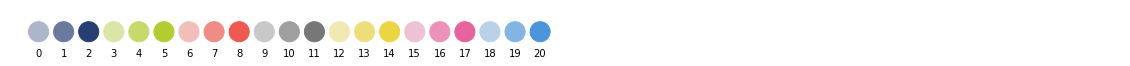

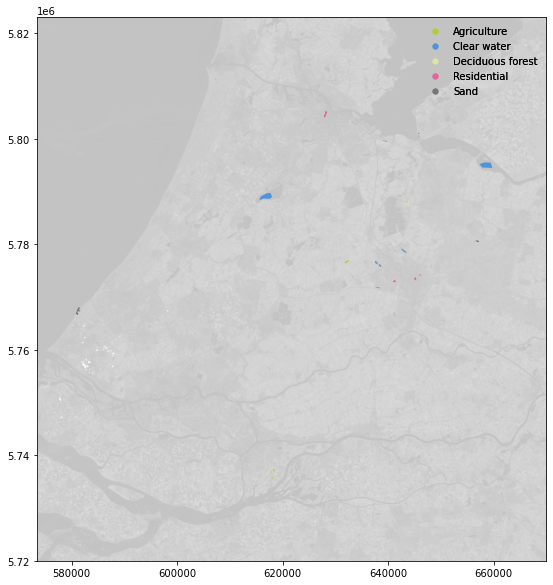

In [2]:
# Below is a visualization of the sample LULC areas superimposed on a satellite image of part of the Netherlands
file_location = 'uu_ml/data/b5_2015.TIF'
b5_2020 = rasterio.open(file_location, nodata=0)

# We also prepare the color codes for visualization
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50), (75, 90, 85), (347, 72, 60), (246, 79, 60)]
cols = []
for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=4)
    for rgb in pal[1:]:
        cols.append(rgb)

# A preview of color codes. Please delete the triple quotation marks to run the code.

fig, ax = plt.subplots(figsize=(20, 5))
for i, c in enumerate(cols):
    ax.add_artist(plt.Circle((i, 0), 0.4, color=c))
    plt.text(i, -1, i, horizontalalignment='center')
    ax.set_axis_off()
    ax.set_aspect(1)
    ax.autoscale()
    plt.xlim(-1.25,43.25)
    plt.ylim(-1,1)


# Assign color codes to LULC types 
symbology = {'Agriculture': cols[5],
             'Clear water': cols[20],
             'Deciduous forest': cols[3],
             'Residential': cols[17],
             'Sand': cols[11]}

# Visualize
fig,ax = plt.subplots(1,1, figsize=(10,10))
show(b5_2020, ax=ax, cmap='gray', alpha=0.25)
aoi.plot(ax=ax, column='land_cover', legend=True, color=aoi['land_cover'].map(symbology))

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax.add_artist(leg_points)

These manually delineated/classified sample LULC types are already prepared in a *.csv* file. You can test the **K-means** on these sample LULC areas after loading this file.

In [3]:
import pandas as pd
lulc = pd.read_csv('uu_ml/data/stack_aoi_2015.csv')

# View some sample rows of the data
lulc.head()

,Unnamed: 0,B1,B2,B3,B4,B5,B6,B7,aoi
0,1902216,8906,9144,9577,9849,12021,12200,11311,31.0
1,1905436,8781,8938,9394,9550,11382,11727,10709,31.0
2,1905437,9071,9151,9620,10164,12103,13131,12497,31.0
3,1905438,9177,9319,9903,10534,13304,14292,13025,31.0
4,1908657,9048,9202,9670,9633,11398,11684,11125,31.0


As you saw that there are 7 bands involved in this dataset, thus each of the pixels is measured by 7 spectral values, and can potentially be characterized in a feature space as high as 7 dimensions. But as mentioned above, lower dimensions would be helpful to visualize the data. We will then visualize the dataset with different band combination to see how the patterns of LULC classes represented in feature space of 2 dimensions.

We will again use the ***seaborn*** module to conduct the visual comparison.

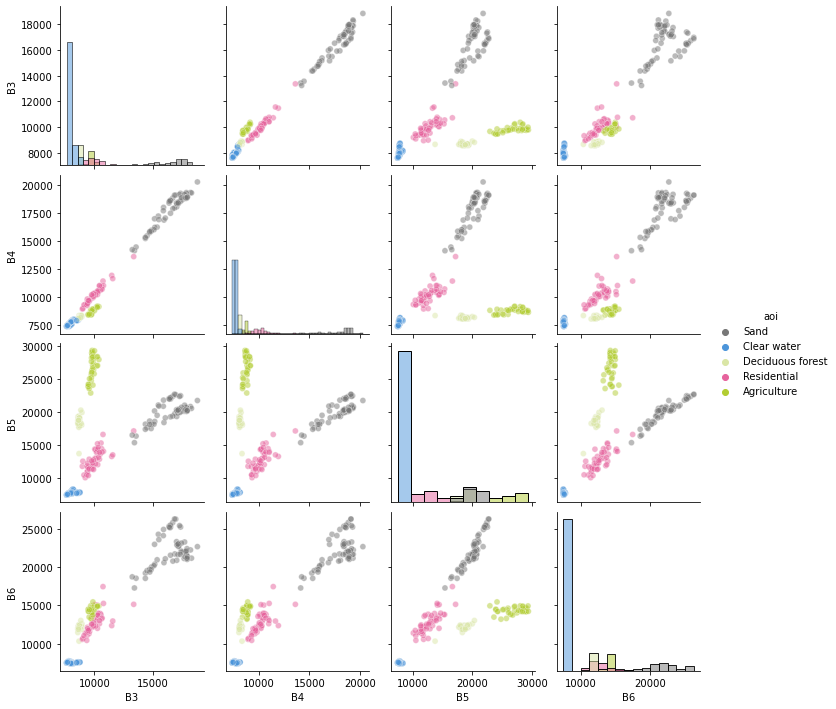

In [4]:
# As you can see, we are using a subset of the dataset for "speed" plotting
lulc_sub = lulc.sample(n=500)

# Adjust aoi numbers to land cover
aoi['aoi_cat'] = pd.Categorical(aoi['class'])
classes = aoi.loc[:,['land_cover', 'aoi_cat']].drop_duplicates()
class_dict = {k:v for k,v in zip(classes.aoi_cat, classes.land_cover)}
lulc_sub.replace({'aoi': class_dict}, inplace=True)
sns.pairplot(lulc_sub.loc[:,['B3', 'B4', 'B5', 'B6', 'aoi']], hue='aoi', palette=symbology, diag_kind="hist", 
             plot_kws=dict(linewidth=0.5, alpha=0.5))


Visually, how are the data points separated in the feature space defined by different band combinations? Please note that the ***seaborn.pairplot*** is diagonally symmetric. In the next few cells, you will be experimenting with **K-means** on different band combinations that you think are reasonable.

For example, in the figure above, it seems that band 5 together with anyone of the other bands can separate the 5 LULC types reasonably well. Then let's start with band 5 with another band, say band 6, for a demonstration. To test if the **K-means** will work properly, you can again apply the ***sklearn*** module. Now, let's see if the **K-means** captures the pattern of the classes above.

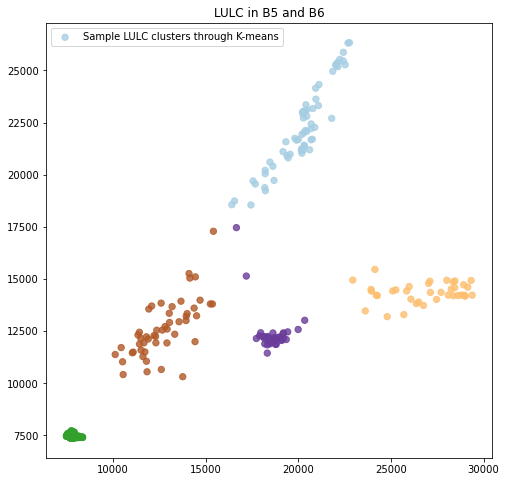

In [5]:
from sklearn import cluster

# Recall that you have to decide the number of clusters.
# But also keep in mind that it is not always easy to make the decision as you would in this case with nicely chosen data.
kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc_sub['B5'].values, lulc_sub['B6'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data

# Try to inspect what exactly contained in the results. For instance, how the 'labels' are created and represented?

# Now all the data points are labelled, you can again visualize the clusters by using the 'labels' just as you did with the 'closest_ind'.
plt.figure(figsize=(8,8))
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8, label='Sample LULC clusters through K-means')
plt.title('LULC in B5 and B6')
plt.legend()

# Compare the results with those you obtained above.

How about all the other band combinations? Is it always good with a combination of two bands?

Text(0.5, 1.0, 'LULC clusters in B5 and B6')

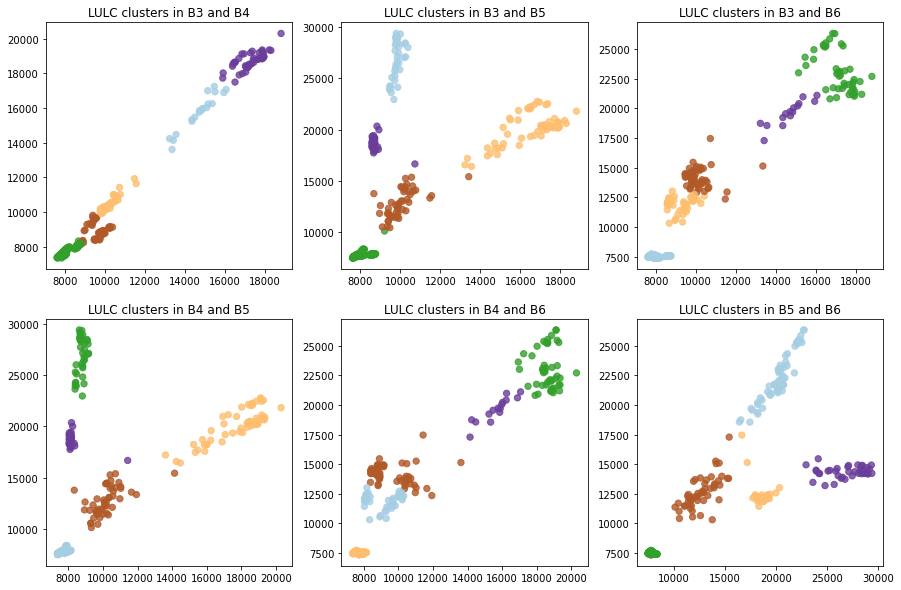

In [6]:
fig = plt.figure(figsize=(15,10))
lb = 'Sample LULC clusters through K-means'

kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc_sub['B3'].values, lulc_sub['B4'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data
plt.subplot(2, 3, 1)
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8)
plt.title('LULC clusters in B3 and B4')
#plt.legend()

kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc_sub['B3'].values, lulc_sub['B5'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data
plt.subplot(2, 3, 2)
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8)
plt.title('LULC clusters in B3 and B5')

kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc_sub['B3'].values, lulc_sub['B6'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data
plt.subplot(2, 3, 3)
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8)
plt.title('LULC clusters in B3 and B6')

kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc_sub['B4'].values, lulc_sub['B5'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data
plt.subplot(2, 3, 4)
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8)
plt.title('LULC clusters in B4 and B5')

kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc_sub['B4'].values, lulc_sub['B6'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data
plt.subplot(2, 3, 5)
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8)
plt.title('LULC clusters in B4 and B6')

kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc_sub['B5'].values, lulc_sub['B6'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data
plt.subplot(2, 3, 6)
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8)
plt.title('LULC clusters in B5 and B6')


Please recall, even for these sample areas, we have only used a subset (500 data points) for the above experiments. Why not to try the **K-means** over the entire dataset of the delineated LULC types? Please go ahead. If some of the bands combination, for instance band 5 and 6, seems good to apply the **K-means** for unsupervised classification, we can of course continue with that.

Text(0.5, 1.0, 'LULC clusters in B5 and B6')

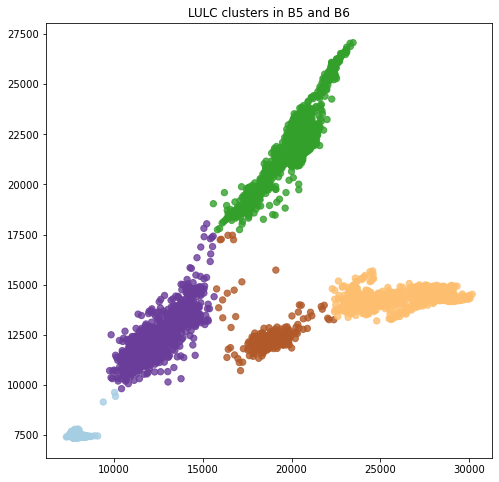

In [7]:
kmean_cluster = cluster.KMeans(n_clusters=5)  # This is a function to be fitted to the data
points = np.c_[lulc['B5'].values, lulc['B6'].values]
labels = kmean_cluster.fit_predict(points)  # Fitting the data

# Try to inspect what exactly contained in the results. For instance, what is the 'kmean_cluster'?

# Now all the data points are labelled, you can again visualize the clusters by using the 'labels' just as you did with the 'closest_ind'.
plt.figure(figsize=(8,8))
plt.scatter(points[:, 0], points[:, 1], s=40, c=labels, cmap='Paired', marker='o', alpha=0.8)
plt.title('LULC clusters in B5 and B6')
#plt.legend()

You may have walked through the first part of this session, where you tried to inspect in details about the update process of the centroid. Let's repeat the procedure on this LULC datasets. Please try different number of centroids to visualize how *proper/improper* number of centroids will lead to different results.

In [8]:
# Few functions to capture the update of the cluster centroids.

def initialize_centroids(points, k):
    """returns k centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    distances = np.sqrt(((points - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

def move_centroids(points, closest, centroids):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])

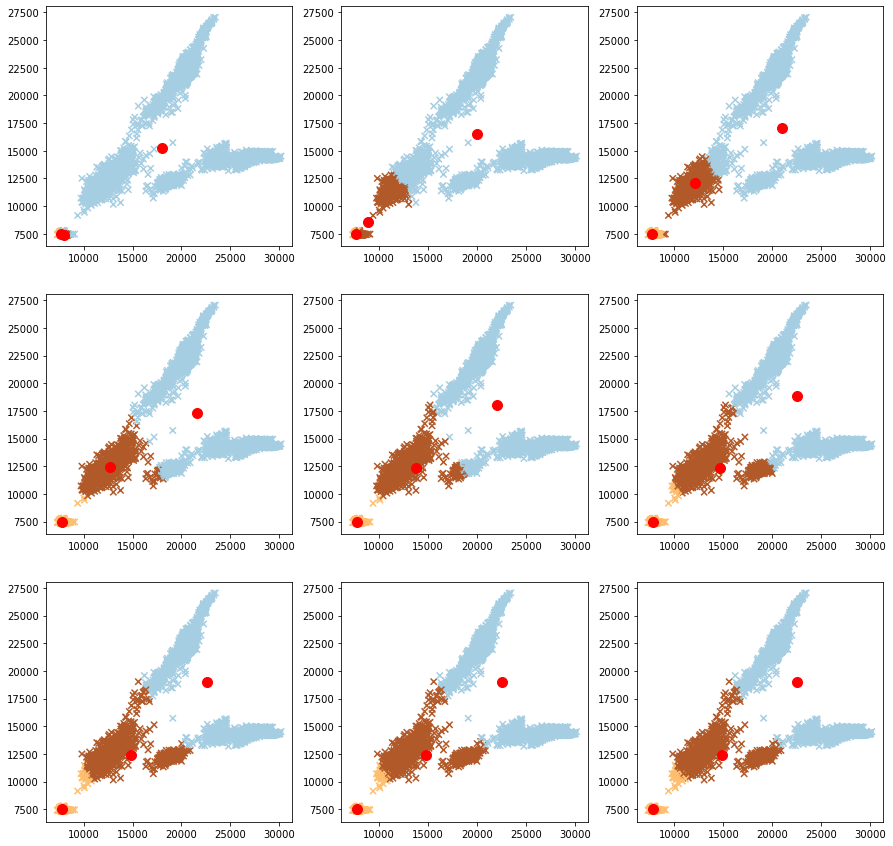

In [10]:
# Try to call your function, and inspect how centroids are updated.
centroids = initialize_centroids(points, 3)

# We can of course visualize how centroids are updated throughout the process.
fig = plt.figure(figsize=(15,15))
for i in range(9):
    closest_ind = closest_centroid(points, centroids)
    centroids = move_centroids(points, closest_ind, centroids)
    plt.subplot(3, 3, i+1)
    plt.scatter(points[:, 0], points[:, 1], s=40, c=closest_ind, cmap='Paired', marker='x', label='training data')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=100)

Now you may wonder how does the **K-means** perform in these few senarios compared to the manually delineated LULC types? In the next section, you will be evaluate the performance through accuracy assessment.

### 0.3 Accuracy assessment.

In this section, we will be evaluate how **K-means** generated clusters capture the pattern of known LULC types. Unlike **supervised** learning where you can always explicitly train your model/algorithm with known targets, as well as evaluate (validate/test) the trained model/algorithm, **unsupervised** learning algorithms such as the **K-means** cannot always be evaluated easily. More often, **unsupervised** learning are most used for exploring the patterns within a given dataset. But here, in our case of mapping LULC in the Netherlands, we can take the manually delineated LULC samples as reliable targets, and use them to do some simple accuracy assessment.

We will first evaluate the performance of the **K-means** on the LULC samples. Then we will apply the **K-means** to larger areas, for instance an area covering almost the entire Netherlands, and see if the automatically generated clusters out of the large dataset would still capture the LULC types in our sample areas.

In order to assess the accuracy, we first need to make the automatically generated clusters and the known LULC types comparable. This means that we need to have an idea about which LULC type is captured by each of the clusters. This further means that we need to interpret the clusters before comparison. Interpretation can of course achieved through visualization, for instance, to see how automatically generated clusters overlap with the sample LULC types. 

Quantitatively, interpreting and comparing automatically generated clusters can be achieved by using the **confusion matrix**, where manually labelled data points can be compared with automatically generated ones. In this case, we will check how a number of pixels in each **K-means** generated cluster will be spreaded over different manually labelled LULC types. Many other more advanced statistics can be derived to assess the performance of the **K-means** as you will see.

In [10]:
# Confusion matrix can be generated by using pandas.

import pandas as pd

y_actu = pd.Series(list(lulc['aoi'].values), name='Manual delineation')
y_pred = pd.Series(list(labels), name='K-means')
df_confusion = pd.crosstab(y_actu, y_pred)

# Show the confusion matrix
df_confusion

K-means,0,1,2,3,4
Manual delineation,,,,,
11.0,5071,0,0,0,0
21.0,0,0,1092,15,4
31.0,3,0,0,1075,11
52.0,0,710,0,0,8
61.0,0,0,0,2,617


In the **confusion matrix**, the clusters are labelled as integers, and the manually delineated LULC types are encoded as: *11 (clear water)*, *21 (sand)*, *31 (residential)*, *52 (agriculture)*, and *61 (deciduous forest)*.

How would you interpret the matrix, for instance, column-wise and row-wise? In this case, for each of the columns, it shows how a specific automatically generated cluster captures many of the labelled LULC types. Preferably, you would like each cluster to be concentrated on one of the LULC types. For each row, it shows how a certain LULC type is simultaneously captured by different clusters. Ideally, you would prefer a LULC type to be captured by only one cluster. In a very undesirable scenario, each cluster would be capturing multiple LULC types, while each LULC type is captured by multiple clusters. This simply means that your clusters does not capture the LULC patterns at all! Thus you would wish each cluster only captures one LULC type, while leaving no extra pixels for other clusters to capture -- a 100% overlapping between clusters and labels!

Take the row labelled as *clear water* for example, it is nicely captured by one of the cluster leaving no chance for the other clusters. But the cluster seems working properly is also capturing something else shown in its column! Now you may already notice two basic scenarios: (1) determine if a cluster corresponds to a certain LULC type, which is actually interpretation of the clusters in terms of LULC types; and (2) Quantify how good each cluster is capturing a LULC type. The later scenarios further boils down to quantify how much a certain cluster captures/misses, and falsely captures.

We can simply interpret the cluster type as the LULC type with the largest number of pixels captured by the cluster. And this number is referred as the **true positive (TP)**. The cluster may still capture other LULC types, which has been known as the **false positive (FP)** as the cluster falsely captures unintended pixels. If the cluster misses some pixels, the missing pixels are **false negative (FN)** as they shouldn't be treated as unintended pixels. For all those pixels in other clusters that are properly missed by this specific cluster are **true negative (TN)**. Given these four quantities, **TP**, **FP**, **TN**, and **FN**, we are ready to derive several accuracy assessment metrics. Essentially, it will be math operations over the values within the **confusion matrix**.

The very first simple metric is the accuracy for each of the cluster, computed as the **(TP+TN)/total**. Take *clear water* for instance, we treate the cluster capturing the most manually delineated *clear water* pixels. Please figure out how the following is obtained. And repeat over different clusters.

In [76]:
tp_cw = 5071
tn_cw = 4+1092+15+11+1075+8+710+617+2
total = np.sum(df_confusion.values)  # Simply take the sum of the confusion matrix

acc_cw = (tp_cw+tn_cw)/total
print('The accuracy of clear water cluster is %.5f' % acc_cw)

The accuracy of clear water cluster is 0.99965


There are also **precision: TP/(TP+FP)** and **recall: TP/(TP+FN)** to measure how a cluster falsely captures and misses the manually delineated LULC types. As the **precision** also captures how the clustering/classification results present on the ground, it is also known as the **user accuracy (UA)**, whereas the **recall** is also referred as **producer accuracy (PA)** as it measures how things on the ground are missing in the results.

In [79]:
# Take clear water for example

fp_cw = 3  # FP of clear water cluster
fn_cw = 0  # FN of clear water cluster

UA_cw = tp_cw/(tp_cw+fp_cw)
PA_cw = tp_cw/(tp_cw+fn_cw)

print('The UA and PA of clear water cluster is %.5f  %.5f' % (UA_cw, PA_cw))

The UA and PA of clear water cluster is 0.99941  1.00000


As the **UA** and **PA** only cover part of the information, you can also derive the **F1 score** combining both accuracy metrics. The **F1 score** is computed as **F1 = 2/(1/UA+1/PA)**. Similar metric can be the **Jaccard index**. Please see more details [here](https://towardsdatascience.com/common-classification-model-evaluation-metrics-2ba0a7a7436e).

In [80]:
# F1 score of clear water cluster
f1_cw = 2/(1/UA_cw+1/PA_cw)

print('The F1 score of clear water cluster is %.5f' % f1_cw)

The F1 score of clear water cluster is 0.99970


The overall accuracy is simply the total **TP** over the total number of pixels. As mentioned above, we take the LULC type with the largest number of pixels captured by a certain cluster as the interpreted LULC type of this specific cluster.

In [71]:
acc_total = np.sum(np.max(df_confusion.values, axis=1))/total
print('The total accuracy of the clusters is %.5f' % acc_total)

The total accuracy of the clusters is 0.99500


Again, as you saw, to assess the accuracy of **unsupervised** learning results, we need to interpret the automatically generated patterns, clusters in this case. Then we could be able to evaluate the performance of our algorithm, the **K-means** in this case. We can make this process more automatic by using a small trick, where we search along each row (LULC type) in the **confusion matrix**, and try to find the column with the largest value, and assign the LULC type of the row to the cluster of that column. In this way, we can automatically interpret the clusters. However, please note that, this small trick is already assuming the clusters are capturing each LULC types reasonably well. If each of the known LULC types is not concentrated in one of the clusters, this trick would not work properly.

In [11]:
# First we need a mapping from both of the LULC codes and cluster indeces to the actual LULC type name.
code_lulc = { 52.0: 'Agriculture',
              11.0: 'Clear water',
              61.0: 'Deciduous forest',
              31.0: 'Residential',
              21.0: 'Sand'}

cluster_lulc = { 0: code_lulc[df_confusion[0].idxmax()],
                 1: code_lulc[df_confusion[1].idxmax()],
                 2: code_lulc[df_confusion[2].idxmax()],
                 3: code_lulc[df_confusion[3].idxmax()],
                 4: code_lulc[df_confusion[4].idxmax()]}

# Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
y_actu2 = y_actu.replace(code_lulc)
y_pred2 = y_pred.replace(cluster_lulc)

In [12]:
# Create a new confusion matrix and print it out to see how it looks like

df_confusion2 = pd.crosstab(y_actu2, y_pred2)

df_confusion2

K-means,Agriculture,Clear water,Deciduous forest,Residential,Sand
Manual delineation,,,,,
Agriculture,710,0,8,0,0
Clear water,0,5071,0,0,0
Deciduous forest,0,0,617,2,0
Residential,0,3,11,1075,0
Sand,0,0,4,15,1092


Now we have a more properly encoded results as you can see in the above **confusion matrix**. Would you try to assess the clustering results over the other LULC types? As you can imagine, there are indeed nicely implemented modules to compute many kinds of accuracy assessment metrics. The ***sklearn*** is the [module](https://scikit-learn.org/stable/modules/model_evaluation.html) we can use again to achieve such purpose. Please compare the results from the ***sklearn*** and the ones we computed above.

In [110]:
# Let's import the relevant module and functionailities

from sklearn.metrics import classification_report

print(classification_report(y_actu2, y_pred2))

                  precision    recall  f1-score   support

     Agriculture       1.00      0.99      0.99       718
     Clear water       1.00      1.00      1.00      5071
Deciduous forest       0.96      1.00      0.98       619
     Residential       0.98      0.99      0.99      1089
            Sand       1.00      0.98      0.99      1111

        accuracy                           1.00      8608
       macro avg       0.99      0.99      0.99      8608
    weighted avg       1.00      1.00      1.00      8608



Please do try different band combinations to assess the performance of the **K-means** with different clustering results. 

But so far, we are still working on a small dataset with few thousands of pixels. This would not happen quite often when we work with larger images. And only looking at the data points in the feature space and **confusion matrix** makes it less interesting for inspecting spatial data. Hence, what's next is that we will be working on larger dataset covering a large fraction of the Netherlands, we will again evaluate the performance of the **K-means**, and we will also inspect the results by mapping the clustered pixels back into space for visualization. 

In the previous examples, we knew there were 5 LULC types, and all the pixels are nicely prepared for you in a *.csv* file. This time, given the spatial extent of a large area, there will be potentially several LULC types, and we don't actually know how many beforehand even there are indeed 5 LULC types in those small AOIs. Thus we will have an extra step to find a proper number of clusters, and we will finetune this number further by comparing the results with the known LULC types from the AOIs.

In [13]:
# Import necessary modules and functionalities

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
from sklearn import cluster

# We need to start with loading and stacking the required bands.
# Again, we start with 2 bands that appeared to be useful for the small dataset.
file_list = ['uu_ml/data/b5_2015.TIF', 'uu_ml/data/b6_2015.TIF']  # List to store file names

# You can print to see how the file_list looks like
print(file_list)

# Read the files and stack them together by calling their names
# Use the 'for' loop to iterate over the names to read files
stack = np.array([])  # Empty array to store the stacked images
for file in file_list:
    img = imread(file)  # Read each image file
    print(img.shape)  # Each time, also check the size of the image
    
    # In order to do clustering, image should be reshaped into a single column
    img_col = img.reshape(-1, 1)
    
    # Each time put the reshaped image into the stack
    stack = np.hstack((stack,img_col)) if stack.size else img_col
    # Also to check the size of the stack
    print(stack.shape)

['data/b5_2015.TIF', 'data/b6_2015.TIF']
(3434, 3221)
(11060914, 1)
(3434, 3221)
(11060914, 2)


It's time for inspecting the number of clusters for the K-means. We will be using the simple ***elbow curve*** method to see how many clusters will be enough to explain the variance in the dataset. Intuitively, you can have as many clusters as the number of data points, but that won't make sense for "clustering". We want the number to be a lot smaller but still sufficient to capture the patterns in the data. In ***sklearn***, there is a metric called the ***inertia*** measures the average distance from data points to their assigned cluster centroids. The measured value would drop along with increasing number of clusters. The value drops very quickly towards a proper number of clusters that reflects the pattern in the data, once the proper number of clusters is reached, the value drops slower as more clusters would not help to reduce the average distance from data points to designated centroids. Hence, if we plot the values of inertia for different number of clusters, the values will form a curve, where the proper number of clusters would appear as the ***elbow*** of the curve as the dropping trend deflects. Still this method is rough, you may always only use it as a reference, and sometimes you will see multiple deflect points along the curve as multiple clustering patterns would potentially present. You also would like to refer to the real context of your study area when choosing the number of clusters.

This can take quite a while with large images...
Cluster number = 2
Cluster number = 3
Cluster number = 4
Cluster number = 5
Cluster number = 6
Cluster number = 7
Cluster number = 8
Cluster number = 9
Cluster number = 10
Cluster number = 11
Cluster number = 12
Cluster number = 13
Cluster number = 14
Cluster number = 15
Cluster number = 16
Cluster number = 17
Cluster number = 18
Cluster number = 19


Text(0.5, 1.0, 'Elbow curve')

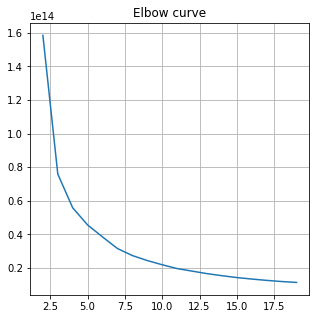

In [54]:
print('This can take quite a while with large images...')

# Inspect some possible number of clusters between 2 and 20.
elbow = []
for k in range(2, 20):
    print('Cluster number = ' + str(k))
    kmean_cluster = cluster.KMeans(n_clusters=k)
    kmean_cluster.fit_predict(stack)
    elbow.append(kmean_cluster.inertia_)

fig = plt.figure(figsize=(5, 5))
plt.plot(range(2, 20), elbow)
plt.grid(True)
plt.title('Elbow curve')

It seems that 7 clusters is appropriate. Without hesitation, let's start to evaluate how 7 clusters capture the LULC patterns in the AOIs. To achieve this, we need to rasterize the *.shp* file of the AOIs into pixels that can be compared to the result of the **K-means**. The rasterization will be based upon spatial format of one of the input *.tif* file.

In [14]:
# Create 7 clusters
kmean_cluster = cluster.KMeans(n_clusters=7)
labels = kmean_cluster.fit_predict(stack)

In [16]:
# Use the rasterio again to rasterize the *.shp file

from rasterio import features

rst = rasterio.open('uu_ml/data/b5_2015.TIF')  # Base image to rasterize the *.shp
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

# Burn the AOIs *.shp file into raster and save it
out_rst = 'uu_ml/data/aoi_rasterized.tif'
with rasterio.open(out_rst, 'w+', **meta) as out:
    out_arr = out.read(1)

    # Create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(aoi.geometry, aoi.aoi_cat))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)


"\nfrom rasterio import features\n\nrst = rasterio.open('uu_ml/data/b5_2015.TIF')  # Base image to rasterize the *.shp\nmeta = rst.meta.copy()  # Copy metadata from the base image\nmeta.update(compress='lzw')\n\n# Burn the AOIs *.shp file into raster and save it\nout_rst = 'uu_ml/data/aoi_rasterized.tif'\nwith rasterio.open(out_rst, 'w+', **meta) as out:\n    out_arr = out.read(1)\n\n    # Create a generator of geom, value pairs to use in rasterizing\n    shapes = ((geom,value) for geom, value in zip(aoi.geometry, aoi.aoi_cat))\n\n    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)\n    out.write_band(1, burned)\n"

In [32]:
# Load the rasterized AOIs for comparison

aoi_rst = rasterio.open('data/aoi_rasterized.tif').read(1)

y_actu = pd.Series(list(aoi_rst.reshape(-1,)), name='Manual delineation')
y_pred = pd.Series(list(labels), name='K-means')


# Only keep pixels in the AOIs
y_pred = y_pred[y_actu.index[y_actu.values != 0]]
y_actu = y_actu[y_actu.index[y_actu.values != 0]]

# As before, take a look at the confusion matrix
df_confusion = pd.crosstab(y_actu, y_pred)

df_confusion

K-means,0,1,2,3,4,6
Manual delineation,,,,,,
11,0,0,4707,0,0,0
21,0,0,0,895,0,0
31,876,0,21,2,0,0
52,0,485,0,0,0,66
61,0,0,0,0,466,4


In [34]:
# Do the code mapping again

# First we need a mapping from both of the LULC codes and cluster indeces to the actual LULC type name.
code_lulc = { 52: 'Agriculture',
              11: 'Clear water',
              61: 'Deciduous forest',
              31: 'Residential',
              21: 'Sand'}

cluster_lulc = { 0: code_lulc[df_confusion[0].idxmax()],
                 1: code_lulc[df_confusion[1].idxmax()],
                 2: code_lulc[df_confusion[2].idxmax()],
                 3: code_lulc[df_confusion[3].idxmax()],
                 4: code_lulc[df_confusion[4].idxmax()],
                 6: code_lulc[df_confusion[6].idxmax()]}

# Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
y_actu2 = y_actu.replace(code_lulc)
y_pred2 = y_pred.replace(cluster_lulc)

# Show the LULC coded confusion matrix
df_confusion2 = pd.crosstab(y_actu2, y_pred2)
df_confusion2

K-means,Agriculture,Clear water,Deciduous forest,Residential,Sand
Manual delineation,,,,,
Agriculture,551,0,0,0,0
Clear water,0,4707,0,0,0
Deciduous forest,4,0,466,0,0
Residential,0,21,0,876,2
Sand,0,0,0,0,895


In [35]:
# Evaluate again.

print(classification_report(y_actu2, y_pred2))

                  precision    recall  f1-score   support

     Agriculture       0.99      1.00      1.00       551
     Clear water       1.00      1.00      1.00      4707
Deciduous forest       1.00      0.99      1.00       470
     Residential       1.00      0.97      0.99       899
            Sand       1.00      1.00      1.00       895

        accuracy                           1.00      7522
       macro avg       1.00      0.99      1.00      7522
    weighted avg       1.00      1.00      1.00      7522



As long as you are satisfied by the results, you can alway map the clusters back into space! Let's visulize the clusters from our **K-means** experiment. 

Please note, in order to keep the legend consistent, recall we already have a customized colormap for different LULC types from ***section 0.2***.

C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


Printing large image takes time...


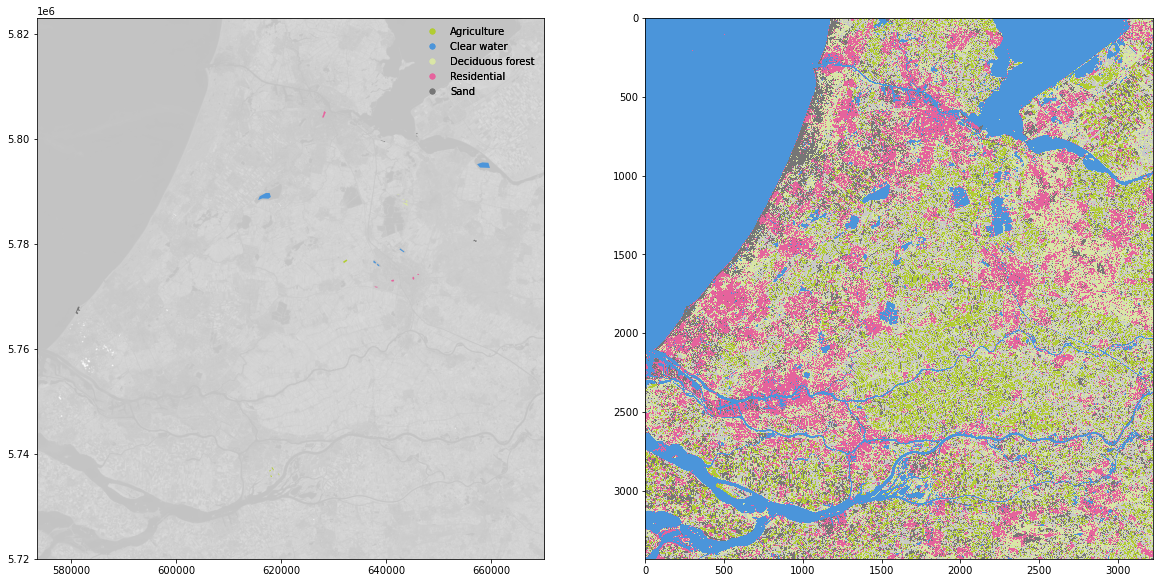

In [52]:
# Assign color codes to LULC types 
symbology = {'Agriculture': cols[5],
             'Clear water': cols[20],
             'Deciduous forest': cols[3],
             'Residential': cols[17],
             'Sand': cols[11]}

# Visualize
fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
show(b5_2020, ax=ax1, cmap='gray', alpha=0.25)
aoi.plot(ax=ax1, column='land_cover', legend=True, color=aoi['land_cover'].map(symbology))

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax1.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax1.add_artist(leg_points)

# Assign color codes to LULC types 
symbology2 = {0: cols[17],
             1: cols[5],
             2: cols[20],
             3: cols[11],
             4: cols[3],
             5: cols[9],
             6: cols[9]}

# Visualize
# Because the predicted labels are still in one column, you need to reshape it back to original image shape
row, col = img.shape  # Get the original dimensions of the image

cm = ListedColormap(symbology2.values())
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

print('Printing large image takes time...')
ax2.imshow(labels.reshape(row, col), cmap=cm, interpolation='none', vmin=imin, vmax=imax)

Are you satisfied with the results? It's your role to continue explore different combinations of input bands for the **K-means** clustering. Try to evaluate the accuracy with 2, 3 or more bands. Also visualize the final maps, and discuss with your classmates about the maps. When you repeat the entire procedure, you are highly encouraged to compile a single piece of repeatable program, it can be a fraction of code above in ***section 0.3***. You are also encouraged to record the results for different scenarios of clutering, for instance, plot how accuracy changes with the changing band combination, number of bands, clusters, etc.

In [ ]:
# Start to load image bands you would like to use:

'''
file_list = ['uu_ml/data/b5_2015.TIF', 'uu_ml/data/b6_2015.TIF', ..., ...,]
'''

# Also load your labelled AOIs, and rasterize it:

'''
aoi = gpd.read_file('...')

rst = rasterio.open('...')  # Base image to rasterize the *.shp
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

...
'''

# Clustering and inspect the number of clusters with different evaluations methods. Some example can be found at: 
# https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a
# or
# https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
# You may still want to try the "elbow" method?

'''
elbow = []
for k in range(2, 20):
    ...
    ...
'''

# Evaluate the accuracy with different number of clusters and bands used

'''
...
...
'''